# Imports

In [118]:
import pandas, json
from pandas.io.json import json_normalize

from os import path, listdir

from math import nan, pi, radians, floor

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data

import numpy

from matplotlib import cm, pyplot

# Magic

In [85]:
%matplotlib inline

# Constants

In [2]:
HOME_PATH = path.join("/home", "jovyan")
SNAPSHOT_PATH = path.join(HOME_PATH, "data", "production", "state", "snapshots.json")
BASE_IMAGE_PATH = '/home/miguel/IdeaProjects/RapBot/'

# Load snapshots

In [3]:
def to_dataframe(file, snapshot_path=SNAPSHOT_PATH):
    dataframe = pandas.read_json(path.join(snapshot_path, file), lines=True)
    return json_normalize(json.loads(dataframe.to_json(orient='records')))
    
def load_snapshot_data(snapshot_path=SNAPSHOT_PATH):
    json_paths = listdir(snapshot_path)
    dataframes = [to_dataframe(file) for file in json_paths]
    
    return pandas.concat(dataframes)

# Clean the snapshots

In [175]:
def remove_empty_rows(data):
    """Filter snapshots without an image"""
    return data.replace({"/dev/null": nan}).dropna(axis=0, how='any')

def localize_paths(data):
    """Replace desktop paths with container paths"""
    return data.apply(lambda p: path.join(HOME_PATH, path.relpath(p, BASE_IMAGE_PATH)))
    
def clean_data(data):
    filtered_data = remove_empty_rows(data)
    filtered_data["imagePath"] = localize_paths(filtered_data["imagePath"])
    return filtered_data

# Add categories to snapshots

In [176]:
def add_quadrant(data):
    data["quadrant"] = data["drive.orientation"].apply(lambda orientation: 1 + floor(radians(orientation) / (pi / 2)))

def add_direction(data):
    data["direction"] = data["drive.orientation"].apply(lambda orientation: "forward" if orientation >= 0 and orientation <= 180 else "reverse")
    
def add_movement(data):
    data["movement"] = data["drive.throttle"].apply(lambda throttle: "stopped" if throttle == 0 else "moving")

# Load the images

In [213]:
def load_image(path):
    """Loads an image given a path."""
    return imread(path, as_grey=True)
    
def transform_image(image):
    # Make segmentation using edge-detection and watershed.
    edges = sobel(image)

    # Identify some background and foreground pixels from the intensity values.
    # These pixels are used as seeds for watershed.
    foreground, background = 1, 2
    
    markers = np.zeros_like(image)
    markers[image < 30.0] = background
    markers[image > 150.0] = foreground

    return watershed(edges, markers)

def image_features(image):
    """Transforms an image into a row of features."""
    return image.reshape(image.shape[0] * image.shape[1])

def load_image_data(data):
    data["image"] = data["imagePath"].apply(lambda p: load_image(p))
    return data

# Prepare

In [212]:
snapshots = load_image_data(clean_data(load_snapshot_data()))

add_quadrant(snapshots)
add_direction(snapshots)
add_movement(snapshots)

snapshots.head()

drive.orientation  drive.throttle  \
1                 90               0   
2                 90               5   
3                 30               5   
4                 30               0   
5                 30               5   

                                           imagePath          start  \
1  /home/jovyan/data/production/images/image48725...  1525650406810   
2  /home/jovyan/data/production/images/image51646...  1525650411211   
3  /home/jovyan/data/production/images/image82544...  1525650412232   
4  /home/jovyan/data/production/images/image92102...  1525650413583   
5  /home/jovyan/data/production/images/image68236...  1525650414664   

   timeWindow    trigger                                  uuid  \
1          82  websocket  e2ce5c18-7f39-4155-8139-e28a22e228e3   
2          98     driver  76f86f63-f9c9-4060-90db-6d3ef8662875   
3          77     driver  2a1e667b-03d3-4683-bd08-8eb95578e27b   
4          63     driver  15dab0e6-eb2e-4287-926d-fbaa875f59cc   
5          56     driver  66f0349b-24c1-49ce-a9a2-72f2d6783964   

   vehicle.backLeft.command.value  vehicle.backLeft.speed  \
1                               4                       0   
2                               1                       5   
3                               1                       5   
4                               1                       0   
5                               1                       5   

   vehicle.backRight.command.value  vehicle.backRight.speed  \
1                                4                        0   
2                                1                        5   
3                                1                        2   
4                                1                        0   
5                                1                        2   

   vehicle.frontLeft.command.value  vehicle.frontLeft.speed  \
1                                4                        0   
2                                1                        5   
3                                1                        5   
4                                1                        0   
5                                1                        5   

   vehicle.frontRight.command.value  vehicle.frontRight.speed  \
1                                 4                         0   
2                                 1                         5   
3                                 1                         2   
4                                 1                         0   
5                                 1                         2   

                                               image  quadrant direction  \
1  [[0.289659215686, 0.289659215686, 0.2896592156...         2   forward   
2  [[0.276487843137, 0.290224705882, 0.2941462745...         2   forward   
3  [[0.272871764706, 0.280714901961, 0.2767933333...         1   forward   
4  [[0.284636470588, 0.288558039216, 0.2924796078...         1   forward   
5  [[0.286303137255, 0.274538431373, 0.2902247058...         1   forward   

  movement  
1  stopped  
2   moving  
3   moving  
4  stopped  
5   moving

# Determine stratification

In [181]:
snapshots["trigger"].value_counts()

snapshot      712
driver        297
websocket       4
$b              1
$a              1
connection      1
Name: trigger, dtype: int64

In [182]:
snapshots["movement"].value_counts()

stopped    857
moving     159
Name: movement, dtype: int64

In [183]:
snapshots["direction"].value_counts()

forward    786
reverse    230
Name: direction, dtype: int64

In [184]:
snapshots["quadrant"].value_counts()

2    692
4    197
1     94
3     33
Name: quadrant, dtype: int64

# Split into train and test sets

In [185]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(snapshots, snapshots["quadrant"]):
    train_set = snapshots.loc[train_index]
    test_set = snapshots.loc[test_index]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [186]:
print(len(train_set), "train + ", len(test_set), "test")

938 train +  234 test


In [189]:
snapshots = train_set

# Visualize the data

In [190]:
def plot_images(instances, shape, images_per_row=10, **options):
    length, width = shape
    
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    
    for i in range(0, n_empty):
        instances.append(numpy.zeros((length, width)))
    
    row_images = []
    for row in range(n_rows):
        rimages = instances[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(numpy.concatenate(rimages, axis=1))
    
    image = numpy.concatenate(row_images, axis=0)
    
    pyplot.figure(figsize=(50, 50))
    pyplot.imshow(image, cmap = cm.gray, **options)
    pyplot.axis("off")
    pyplot.show()

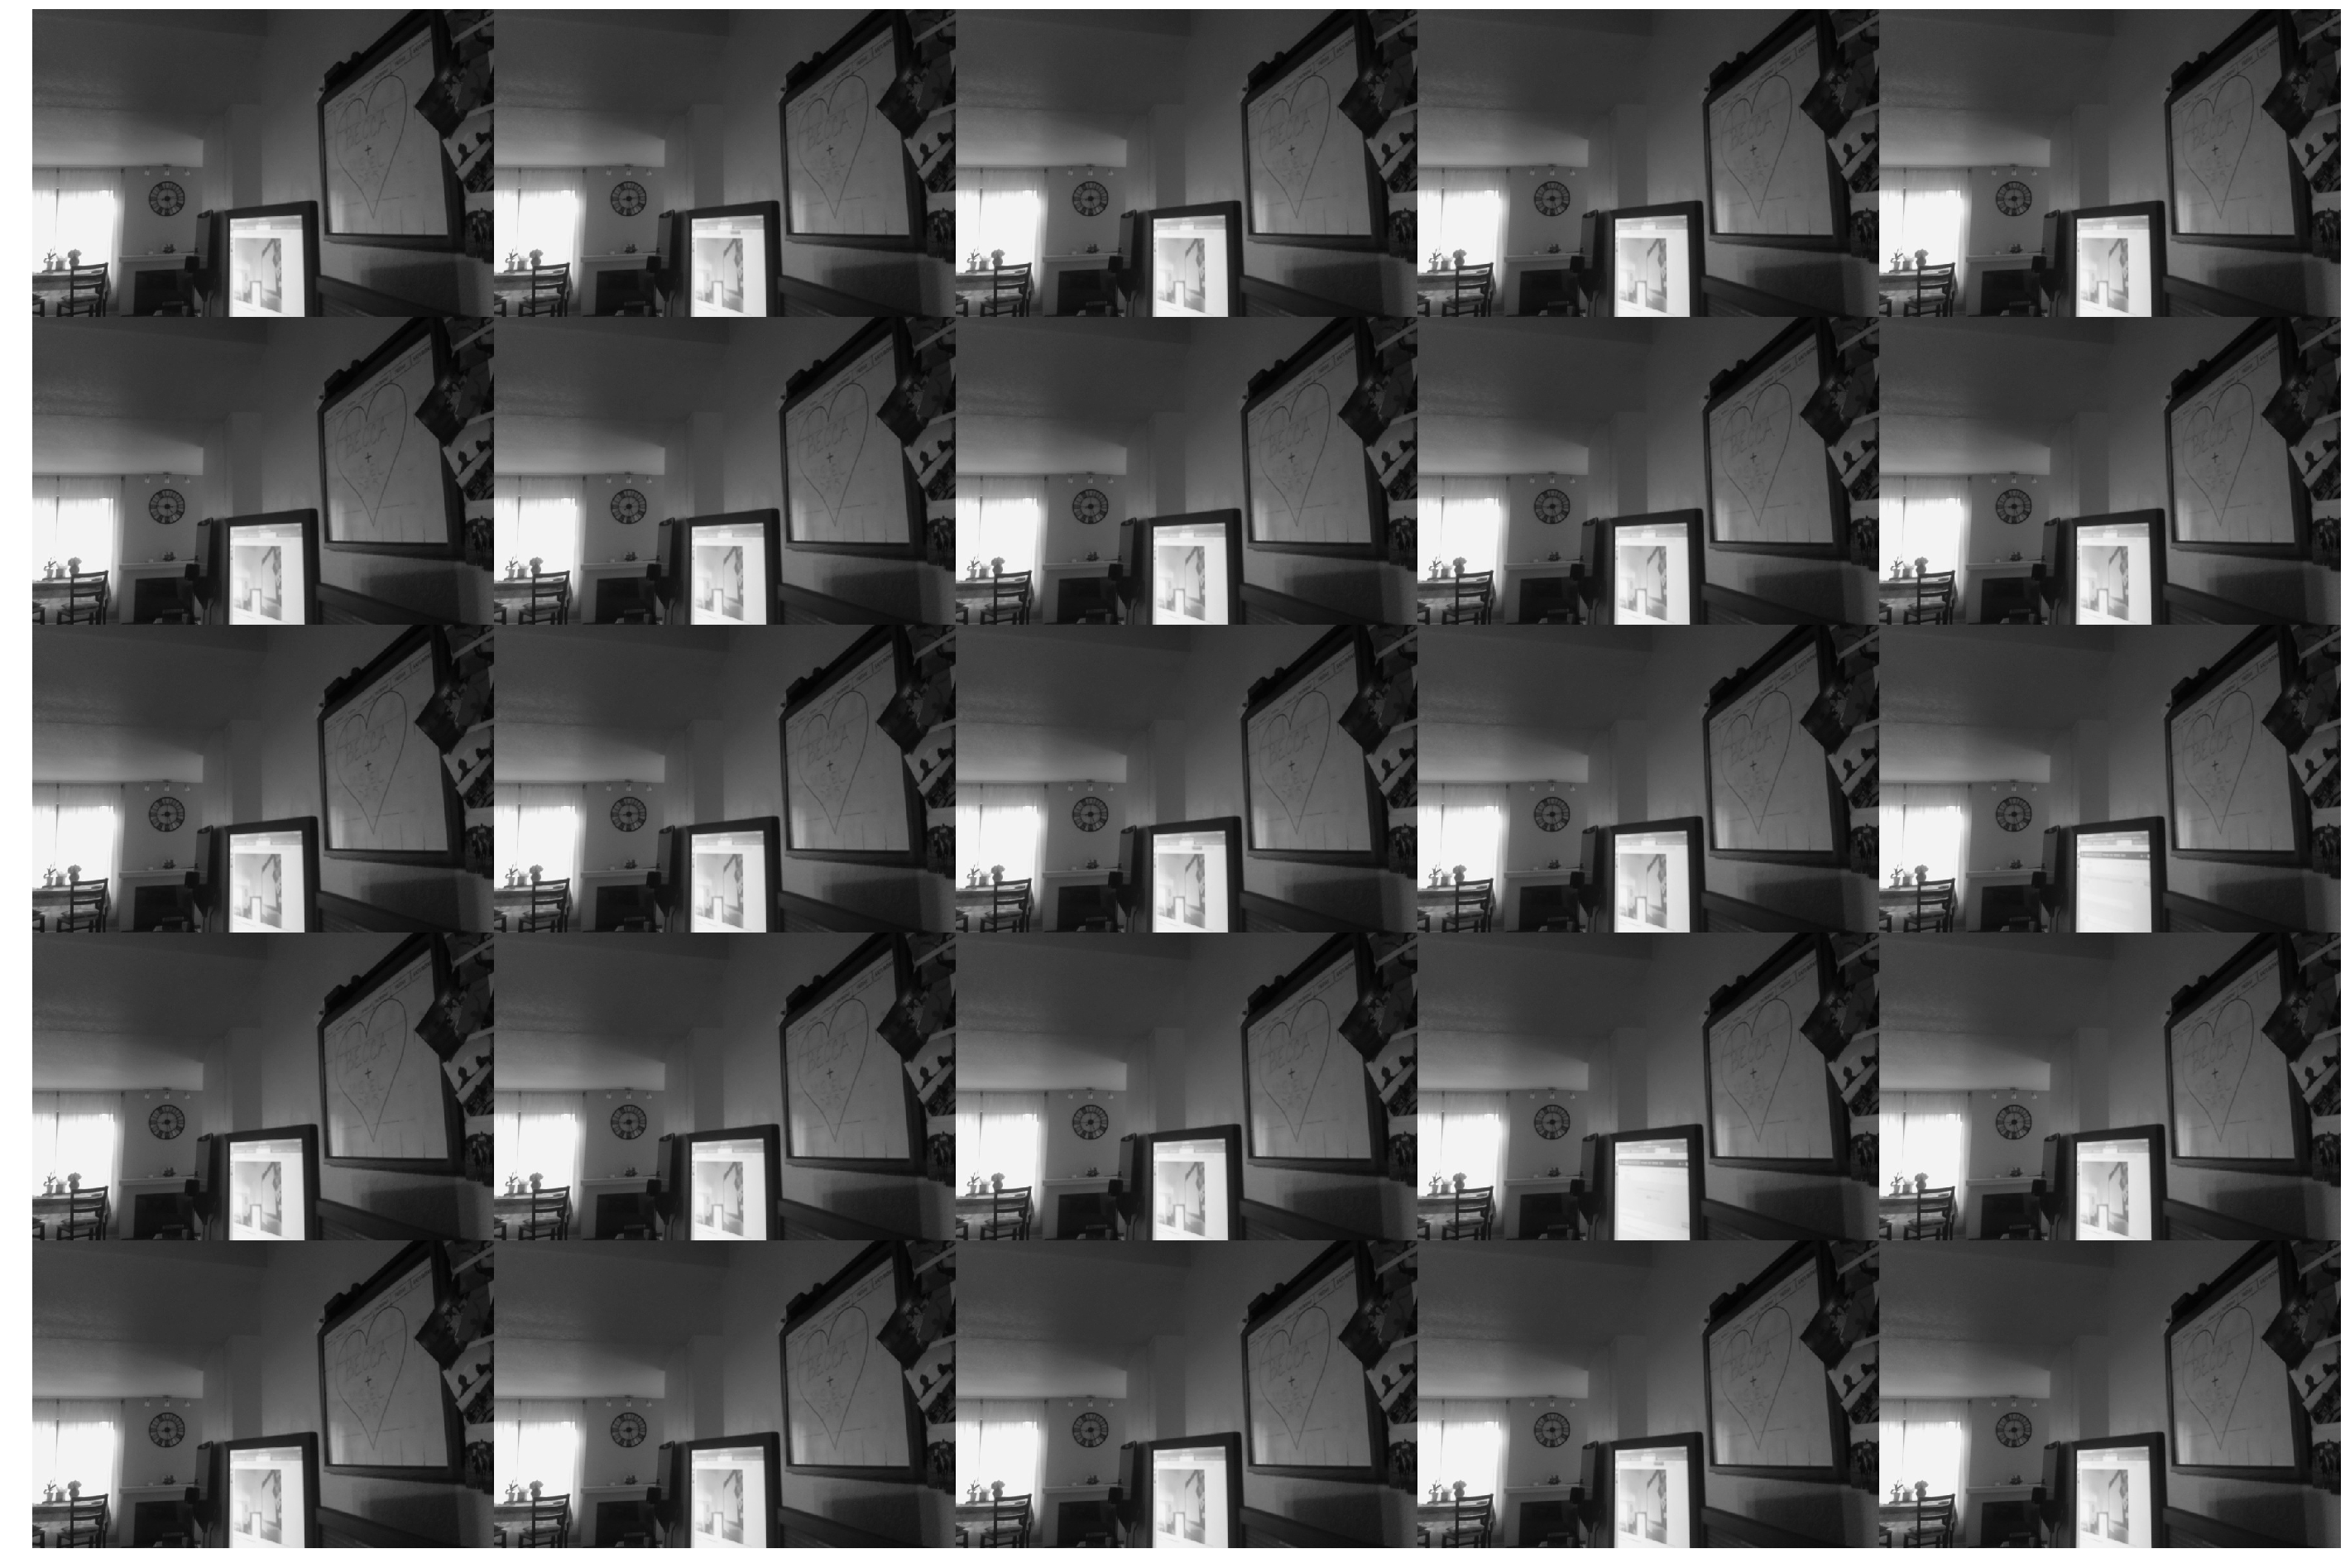

In [191]:
shape = images.head(n=1).values[0].shape
images_per_row = 5
rows = 5
samples = images.sample(n=5*rows).values

plot_images(samples, shape, images_per_row=images_per_row)

In [192]:
snapshots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 938 entries, 569 to 437
Data columns (total 19 columns):
drive.orientation                   818 non-null float64
drive.throttle                      818 non-null float64
imagePath                           818 non-null object
start                               818 non-null float64
timeWindow                          818 non-null float64
trigger                             818 non-null object
uuid                                818 non-null object
vehicle.backLeft.command.value      818 non-null float64
vehicle.backLeft.speed              818 non-null float64
vehicle.backRight.command.value     818 non-null float64
vehicle.backRight.speed             818 non-null float64
vehicle.frontLeft.command.value     818 non-null float64
vehicle.frontLeft.speed             818 non-null float64
vehicle.frontRight.command.value    818 non-null float64
vehicle.frontRight.speed            818 non-null float64
image                               818 n

In [193]:
snapshots.describe()

drive.orientation  drive.throttle         start  timeWindow  \
count         818.000000      818.000000  8.180000e+02  818.000000   
mean          127.555012       13.887531  1.525652e+12   53.019560   
std            81.610998       49.571452  3.935155e+05   18.336234   
min            30.000000        0.000000  1.525650e+12    1.000000   
25%            90.000000        0.000000  1.525652e+12   46.000000   
50%            90.000000        0.000000  1.525652e+12   52.000000   
75%           150.000000        0.000000  1.525652e+12   60.000000   
max           330.000000      255.000000  1.525652e+12  116.000000   

       vehicle.backLeft.command.value  vehicle.backLeft.speed  \
count                      818.000000              818.000000   
mean                         1.568460               13.574572   
std                          0.959821               48.437975   
min                          1.000000                0.000000   
25%                          1.000000                0.000000   
50%                          1.000000                0.000000   
75%                          2.000000                0.000000   
max                          4.000000              255.000000   

       vehicle.backRight.command.value  vehicle.backRight.speed  \
count                       818.000000               818.000000   
mean                          1.568460                 9.590465   
std                           0.959821                36.117038   
min                           1.000000                 0.000000   
25%                           1.000000                 0.000000   
50%                           1.000000                 0.000000   
75%                           2.000000                 0.000000   
max                           4.000000               255.000000   

       vehicle.frontLeft.command.value  vehicle.frontLeft.speed  \
count                       818.000000               818.000000   
mean                          1.568460                13.574572   
std                           0.959821                48.437975   
min                           1.000000                 0.000000   
25%                           1.000000                 0.000000   
50%                           1.000000                 0.000000   
75%                           2.000000                 0.000000   
max                           4.000000               255.000000   

       vehicle.frontRight.command.value  vehicle.frontRight.speed    quadrant  
count                        818.000000                818.000000  818.000000  
mean                           1.568460                  9.590465    2.337408  
std                            0.959821                 36.117038    0.896665  
min                            1.000000                  0.000000    1.000000  
25%                            1.000000                  0.000000    2.000000  
50%                            1.000000                  0.000000    2.000000  
75%                            2.000000                  0.000000    2.000000  
max                            4.000000                255.000000    4.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a57347cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5a55c99208>]], dtype=object)

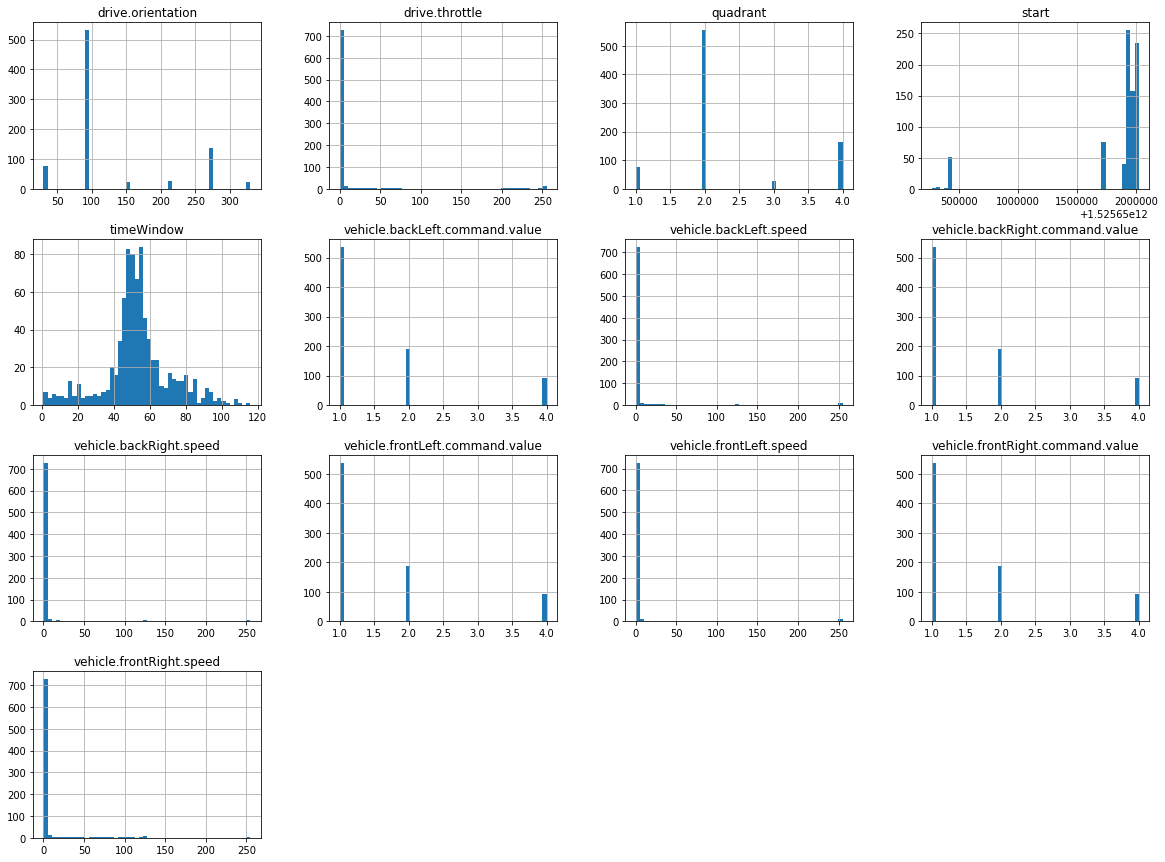

In [194]:
snapshots.hist(bins=50, figsize=(20, 15))

In [195]:
corr_matrix = snapshots.corr()
corr_matrix["drive.orientation"].sort_values(ascending=False)

drive.orientation                   1.000000
quadrant                            0.979738
vehicle.frontRight.command.value    0.255901
vehicle.frontLeft.command.value     0.255901
vehicle.backRight.command.value     0.255901
vehicle.backLeft.command.value      0.255901
start                               0.204940
timeWindow                         -0.055751
vehicle.frontRight.speed           -0.124361
vehicle.backRight.speed            -0.124361
drive.throttle                     -0.194245
vehicle.frontLeft.speed            -0.200569
vehicle.backLeft.speed             -0.200569
Name: drive.orientation, dtype: float64

# Train a model

In [ ]:
X = snapshots["drive.orientation"].values
y = snapshots["image"].apply(lambda image: image_features(image)).values

(345600,)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(images, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse